# PBupsModel with Algorithmic Differentiation in Julia

In [1]:
# import packages..
import ForwardDiff
using ForwardDiff
using PyPlot
import Base.convert
import Optim
using Optim

# === Upgrading from ForwardDiff v0.1 to v0.2
# instead of ForwardDiff.GradientNumber and ForwardDiff.HessianNumber, 
# we will use ForwardDiff.Dual

convert(::Type{Float64}, x::ForwardDiff.Dual) = Float64(x.value)
function convert(::Array{Float64}, x::Array{ForwardDiff.Dual}) 
    y = zeros(size(x)); 
    for i in 1:prod(size(x)) 
        y[i] = convert(Float64, x[i]) 
    end
    return y
end


convert (generic function with 557 methods)

In [2]:
immutable NumericPair{X,Y} <: Number
  x::X
  y::Y
end
Base.isless(a::NumericPair, b::NumericPair) = (a.x<b.x) || (a.x==b.x && a.y<b.y)

isless (generic function with 46 methods)

To evaluate how well a particular set of parameter values $\theta$ fits the behavioral data, we compute the probability of oberving the data given the model.

For each trial $i$, we will compute the likelihood of seeing the data under the model assuming that trials are independent. 

$P(D|\theta) = \prod_{i}P(d_i|t_{i,R},t_{i,L},\theta)$

$t_{i,R},t_{i,L}$ : the right and left click times on trial $i$

$d_i$ : the subject's decision on trial $i$

The best-fit parameter values are the parameters $\theta$ that maximize the likelihood (Maximum likelihood values)

To help maximize the likelihood(or log likelihood), we will compute the derivative $\partial P(d_i|t_{i,R},t_{i,L},\theta) / \partial\theta$ for each of the parameters in the set $\theta$.

After we get these gradients of 9 model parameters, we will apply them for optimization.

## Import data 

In [3]:
using MAT
ratdata = matread("testdata.mat")
# ratdata = matread("chrono_B069_rawdata.mat")

Dict{ByteString,Any} with 5 entries:
  "ratname"      => "B069"
  "daterange"    => 1x2 Array{Any,2}:…
  "avgdata"      => Dict{ASCIIString,Any}("is_probe"=>1x64537 Array{Bool,2}:…
  "rawdata"      => Dict{ASCIIString,Any}("is_probe"=>1x64537 Array{Any,2}:…
  "total_trials" => 64537.0

In [4]:
function trialdata(rawdata, trial::Int)
    if rawdata["pokedR"][trial] > 0
        rat_choice = 1;  # "R"
    else
        rat_choice = -1; # "L"
    end;
    
    if typeof(rawdata["rightbups"][trial]) <: Array
        rvec = vec(rawdata["rightbups"][trial])::Array{Float64,1};
    else
        rvec = Float64[]
    end
    if typeof(rawdata["leftbups"][trial]) <: Array
        lvec = vec(rawdata["leftbups"][trial])::Array{Float64,1};
    else
        lvec = Float64[]
    end
    
    return rvec, lvec, 
    rawdata["T"][trial]::Float64, rat_choice
end

RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], 1)

([0.0,0.001135000000000004,0.011165000000000001,0.01892,0.10638,0.20342,0.32964499999999997,0.33775999999999995],[0.0,0.19235,0.34360999999999997],0.35095899999999747,-1)

In [5]:
@time RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], 1)

  0.000062 seconds (159 allocations: 10.511 KB)


([0.0,0.001135000000000004,0.011165000000000001,0.01892,0.10638,0.20342,0.32964499999999997,0.33775999999999995],[0.0,0.19235,0.34360999999999997],0.35095899999999747,-1)

## bin_centers = make_bins(B, dx, binN)

In [6]:
"""
function bin_centers = make_bins(B, dx, binN)

Makes a series of points that will indicate bin centers. The first and
last points will indicate sticky bins. No "bin edges" are made-- the edge
between two bins is always implicity at the halfway point between their
corresponding centers. The center bin is always at x=0; bin spacing
(except for last and first bins) is always dx; and the position
of the first and last bins is chosen so that |B| lies exactly at the
midpoint between 1st (sticky) and 2nd (first real) bins, as well as
exactly at the midpoint between last but one (last real) and last
(sticky) bins.

Playing nice with ForwardDiff means that the *number* of bins must be predetermined.
So this function will not actually set the number of bins; what it'll do is determine their
locations. To accomplish this separation, the function uses as a third parameter binN,
which should be equal to the number of bins with bin centers > 0, as follows: 
   binN = ceil(B/dx)
and then the total number of bins will be 2*binN+1, with the center one always corresponding
to position zero. Use non-differentiable types for B and dx for this to work.
"""
function make_bins{T}(bins::Vector{T}, B, dx::T, binN)
    cnt = 1
    for i=-binN:binN
        bins[cnt] = i*dx
        cnt = cnt+1
    end
    
    if binN*dx == B
        bins[end] = B + dx
        bins[1] = -B - dx
    else
        bins[end] = 2*B - (binN-1)*dx
        bins[1] = -2*B + (binN-1)*dx
    end
end;

In [7]:
binN = ceil(4.1/0.25)
bins = zeros(typeof(binN), Int(binN*2+1))
@time make_bins(bins,4.1,0.25,binN)
bins
bin_centers = bins

  0.063969 seconds (60.10 k allocations: 2.411 MB)


35-element Array{Float64,1}:
 -4.2 
 -4.0 
 -3.75
 -3.5 
 -3.25
 -3.0 
 -2.75
 -2.5 
 -2.25
 -2.0 
 -1.75
 -1.5 
 -1.25
  ⋮   
  1.5 
  1.75
  2.0 
  2.25
  2.5 
  2.75
  3.0 
  3.25
  3.5 
  3.75
  4.0 
  4.2 

## Global Variables

In [8]:
# Global variables 
const epsilon = 10.0^(-10);
const dx = 0.25;
const dt = 0.02;
const total_rate = 40;

## Parameters

a : decision variable, memory accumulator

$$ da =
  \begin{cases}
    0       & \quad \text{if, } |a| \geq B \\
    \sigma_adW + (\delta_{t,t_R} \cdot \eta C(t) - \delta_{t,t_L} \cdot \eta C(t))dt + \lambda adt  & \quad \text{otherwise, }\\
  \end{cases}
$$



The impact of each click (C) is affected by sensory adaptation that depends on clicks from both right and left sides:

$$ 
\frac{\mathrm d C}{\mathrm d t} = \frac{1-C}{\tau_\phi} + (1-\phi)C(\delta_{t,t_R}+\delta_{t,t_L}) 
$$


sigma2_a ($\sigma_a^2$) : a diffusion constant, parameterizing noise in a.

sigma2_s ($\sigma_s^2$) : parameterizing noise when adding evidence from a right or left pulse. (incoming sensory evidence)

sigma2_i ($\sigma_i^2$) : initial condition for the dynamical equation at $t=0$

lam ($\lambda$) : consistent drift in the memory a ($\lambda<0$ : leaky or forgetful case, $\lambda>0$ : unstable or impulsive case)

B : decision bound

bias : bias parameter determines the position of the threshold in a (which a Rightward decision is made)

phi ($\phi$) : parameterize sensory adaptation (by defining the dynamics of C ($\phi>1$ : Facilitation, $\phi<1$ : Depression, $\phi=1$ : absense of sensory adaptation)

tau_phi ($\tau_\phi$) :

lapse : The lapse rate parameterizes the probability of making a random response.


In [9]:
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

sigma = params[1];
lam   = params[2];
c     = params[3];

## F = Fmatrix([sigma, lambda, c], bin_centers)

In [10]:
"""
function F = Fmatrix([sigma, lambda, c], bin_centers)

Uses globals
    dt
    dx
    epsilon       (=10.0^-10)

Returns a square Markov matrix of transition probabilities. 
Plays nice with ForwardDiff-- that is why bin_centers is a global vector (so that the rem
operations that go into defining the bins, which ForwardDiff doesn't know how to deal with,
stay outside of this differentiable function)

sigma  should be in (accumulator units) per (second^(1/2))
lambda should be in s^-1
c      should be in accumulator units per second
bin_centers should be a vector of the centers of all the bins. Edges will be at midpoints
       between the centers, and the first and last bin will be sticky.

dx is not used inside Fmatrix, because bin_centers specifies all we need to know.
dt *is* used inside Fmatrix, to convert sigma, lambda, and c into timestep units
"""
function Fmatrix{T}(F::AbstractArray{T,2},params::Vector, bin_centers)
    sigma2 = params[1];
    lam   = params[2];
    c     = params[3];
    
    sigma2_sbin = convert(Float64, sigma2)
      
    n_sbins = max(70, ceil(10*sqrt(sigma2_sbin)/dx))
    
    swidth = 5*sqrt(sigma2_sbin)
    sbinsize = swidth/n_sbins;#sbins[2] - sbins[1]
    base_sbins    = collect(-swidth:sbinsize:swidth)
    
    ps       = exp(-base_sbins.^2/(2*sigma2))
    ps       = ps/sum(ps);
    
    sbin_length = length(base_sbins)
    binN = length(bin_centers)

    mu = 0.
    for j in 2:binN
        if lam == 0
            mu = bin_centers[j]*exp(lam*dt)
        else
            mu = (bin_centers[j] + c/lam)*exp(lam*dt) - c/lam
        end
        
        for k in 1:sbin_length
            sbin = (k-1)*sbinsize + mu - swidth
             
            if sbin < bin_centers[1] #(bin_centers[1] + bin_centers[2])/2
                F[1,j] = F[1,j] + ps[k]
            elseif bin_centers[end] <= sbin#(bin_centers[end]+bin_centers[end-1])/2 <= sbins[k]
                F[end,j] = F[end,j] + ps[k]
            else # more condition
                if (sbin > bin_centers[1] && sbin < bin_centers[2])
                    lp = 1; hp = 2;
                elseif (sbin > bin_centers[end-1] && sbin < bin_centers[end])
                    lp = binN-1; hp = binN;
                else 
                    lp = floor(Int,((sbin-bin_centers[2])/dx) + 2)#find(bin_centers .<= sbins[k])[end]
                    hp = lp+1#Int(ceil((sbins[k]-bin_centers[2])/dx) + 1);
                end

                if lp < 1 
                    lp = 1; 
                end
                if hp < 1 
                    hp = 1;
                end

                if lp == hp
                    F[lp,j] = F[lp,j] + ps[k]
                else
                    F[hp,j] = F[hp,j] + ps[k]*(sbin - bin_centers[lp])/(bin_centers[hp] - bin_centers[lp])
                    F[lp,j] = F[lp,j] + ps[k]*(bin_centers[hp] - sbin)/(bin_centers[hp] - bin_centers[lp])
                end                   
            end
        end
    end
    F[:,1] = 0; F[:,end] = 0; F[1,1] = 1; F[end,end] = 1;
end

Fmatrix (generic function with 1 method)

In [11]:
F = zeros(typeof(0.2),length(bin_centers),length(bin_centers))
@time Fmatrix(F,[0.2, 0, 0.0],bin_centers) # Fi
F

  0.237063 seconds (149.43 k allocations: 6.909 MB, 3.01% gc time)


35x35 Array{Float64,2}:
 1.0  0.41182      0.218907     0.0917964    …  0.0          0.0          0.0
 0.0  0.197142     0.172131     0.112014        0.0          0.0          0.0
 0.0  0.187228     0.217923     0.187228        0.0          0.0          0.0
 0.0  0.119939     0.187228     0.217923        0.0          0.0          0.0
 0.0  0.0571377    0.119939     0.187228        0.0          0.0          0.0
 0.0  0.0202246    0.0571377    0.119939     …  0.0          0.0          0.0
 0.0  0.00531176   0.0202246    0.0571377       0.0          0.0          0.0
 0.0  0.00103206   0.00531176   0.0202246       0.0          0.0          0.0
 0.0  0.000148294  0.00103206   0.00531176      0.0          0.0          0.0
 0.0  1.59548e-5   0.000148294  0.00103206      0.0          0.0          0.0
 0.0  1.11105e-6   1.59548e-5   0.000148294  …  0.0          0.0          0.0
 0.0  0.0          1.11105e-6   1.59548e-5      0.0          0.0          0.0
 0.0  0.0          0.0          1.11105e

In [12]:
F = zeros(typeof(params[1]),length(bin_centers),length(bin_centers))
@time Fmatrix(F,params,bin_centers)
F

  0.000084 seconds (13 allocations: 7.547 KB)


35x35 Array{Float64,2}:
 1.0  0.461125    0.365007    0.274946    …  0.0         0.0         0.0
 0.0  0.0908452   0.0859592   0.0811359      0.0         0.0         0.0
 0.0  0.0945948   0.100835    0.0946575      0.0         0.0         0.0
 0.0  0.0888839   0.0945533   0.100892       0.0         0.0         0.0
 0.0  0.0737024   0.0889555   0.0945117      0.0         0.0         0.0
 0.0  0.0612142   0.0736883   0.0890271   …  0.0         0.0         0.0
 0.0  0.044833    0.0612781   0.0736743      0.0         0.0         0.0
 0.0  0.0329193   0.0448354   0.0613421      0.0         0.0         0.0
 0.0  0.0212918   0.0329616   0.0448377      0.0         0.0         0.0
 0.0  0.0138235   0.021298    0.0330038      0.0         0.0         0.0
 0.0  0.0078944   0.0138445   0.0213041   …  0.0         0.0         0.0
 0.0  0.00453257  0.0078985   0.0138655      0.0         0.0         0.0
 0.0  0.00228512  0.00454054  0.00790261     3.13941e-7  0.0         0.0
 ⋮                         

## logProbRight 
### (params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int)

* params = [sigma_a, sigma_s, sigma_i, lambda, B, bias, phi, tau_phi, lapse]
* RightClickTimes vector with elements indicating times of right clicks
* LeftClickTimes vector with elements indicating times of left clicks
* Nsteps number of timesteps to simulate 

a (column vector representing distribution of values of accumulator a)

a_trace (length(bin_centers)-by-Nsteps+1), a trace of the distribution of a as 
    a function of time
    
c_trace (row vector Nsteps+1 long, effective value of c as 
    a function of time after adaptation)


In [13]:
"""
version with inter-click interval(ici) for c_eff_net / c_eff_tot (followed the matlab code) 
(which was using dt for c_eff)

function logProbRight(params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int)

    Nsteps            number of timesteps to simulate
    RightClickTimes   vector with elements indicating times of right clicks
    LeftClickTimes    vector with elements indicating times of left clicks

    a      (column vector representing distribution of values of accumulator a)

    a_trace (length(bin_centers)-by-Nsteps+1), a trace of the distribution of a as 
            a function of time
    c_trace (row vector Nsteps+1 long, effective value of c as 
            a function of time after adaptation)

Takes params
    sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]

Returns the log of the probability that the agent chose Right. 
"""

function logProbRight(params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int)
    sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]
    
    if isempty(RightClickTimes) RightClickTimes = zeros(0) end;
    if isempty(LeftClickTimes ) LeftClickTimes  = zeros(0) end;
    
    NClicks = zeros(Int, Nsteps); 
    Lhere  = zeros(Int, length(LeftClickTimes)); 
    Rhere = zeros(Int, length(RightClickTimes)); 
    
    for i in 1:length(LeftClickTimes)
        Lhere[i] = ceil((LeftClickTimes[i]+epsilon)/dt)
    end
    for i in 1:length(RightClickTimes)
        Rhere[i] = ceil((RightClickTimes[i]+epsilon)/dt)
    end    
    
    for i in Lhere  
        NClicks[Int(i)] = NClicks[Int(i)]  + 1
    end
    for i in Rhere  
        NClicks[Int(i)] = NClicks[Int(i)]  + 1
    end
    
    # === Upgrading from ForwardDiff v0.1 to v0.2
    # instead of using convert we can use floor(Int, ForwardDiff.Dual) and
    # ceil(Int, ForwardDiff.Dual)

    binN = ceil(Int, B/dx)#Int(ceil(my_B/dx))  
    binBias = floor(Int, bias/dx) + binN+1  
    bin_centers = zeros(typeof(dx), binN*2+1)
    make_bins(bin_centers, B, dx, binN)  

    a0 = zeros(typeof(sigma_a),length(bin_centers))
    a0[binN+1] = 1-lapse; a0[1] = lapse/2; a0[end] = lapse/2;
    
    temp_l = [NumericPair(LeftClickTimes[i],-1) for i=1:length(LeftClickTimes)]
    temp_r = [NumericPair(RightClickTimes[i],1) for i=1:length(RightClickTimes)]
    allbups = sort!([temp_l; temp_r])

    c_eff = 0.
    cnt = 0
        
    Fi = zeros(typeof(sigma_i),length(bin_centers),length(bin_centers))
    Fmatrix(Fi,[sigma_i, 0., 0.0], bin_centers)
    a = Fi*a0;
    
    F0 = zeros(typeof(sigma_a),length(bin_centers),length(bin_centers))
    Fmatrix(F0,[sigma_a*dt, lambda, 0.0], bin_centers)
    for i in 2:Nsteps 
        c_eff_tot = 0.
        c_eff_net = 0.
        if NClicks[i-1]==0
            c_eff_tot = 0.
            c_eff_net = 0.
            a = F0*a
        else
            for j in 1:NClicks[i-1]
                if cnt != 0 || j != 1
                    ici = allbups[cnt+j].x - allbups[cnt+j-1].x
                    c_eff = 1 + (c_eff*phi - 1)*exp(-ici/tau_phi)
                    c_eff_tot = c_eff_tot + c_eff
                    c_eff_net = c_eff_net + c_eff*allbups[cnt+j].y
                end
                if j == NClicks[i-1]
                    cnt = cnt+j
                end
            end

            net_sigma = sigma_a*dt + (sigma_s*c_eff_tot)/total_rate
            F = zeros(typeof(net_sigma),length(bin_centers),length(bin_centers))
            Fmatrix(F,[net_sigma, lambda, c_eff_net/dt], bin_centers)
            a = F*a
        end
    end
#     plot(1:Nsteps+1,c_trace[:])    
#     imshow(a_trace, interpolation="none")
    pright = sum(a[binBias+2:end]) + 
    a[binBias]*((bin_centers[binBias+1] - bias)/dx/2) +
    a[binBias+1]*(0.5 + (bin_centers[binBias+1] - bias)/dx/2)
    
    return log(pright)
end

function logLike(params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int, rat_choice::Int)
    if rat_choice > 0
        # println("Right")
        return logProbRight(params, RightClickTimes, LeftClickTimes, Nsteps)
    elseif rat_choice < 0
        # println("Left")
        return log(1 - exp(logProbRight(params, RightClickTimes, LeftClickTimes, Nsteps)))
    else
        error("Rat did what?? It was neither R nor L")
    end
end

logLike (generic function with 1 method)

## single_trial
### (params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int, rat_choice::Int)

In [14]:
""" 
function (LL, LLgrad) = 
    single_trial(params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int, rat_choice::Int)

Computes the log likelihood according to Bing's model, and returns log likelihood, gradient

params is a vector whose elements, in order, are
    sigma_a    square root of accumulator variance per unit time sqrt(click units^2 per second)
    sigma_s    standard deviation introduced with each click (will get scaled by click adaptation)
    sigma_i    square root of initial accumulator variance sqrt(click units^2)
    lambda     1/accumulator time constant (sec^-1). Positive means unstable, neg means stable
    B          sticky bound height (click units)
    bias       where the decision boundary lies (click units)
    phi        click adaptation/facilitation multiplication parameter
    tau_phi    time constant for recovery from click adaptation (sec)
    lapse      2*lapse fraction of trials are decided randomly

rat_choice     should be either "R" or "L"


RETURNS:


"""
# === Upgrading from ForwardDiff v0.1 to v0.2
# for Retrieving Lower-Order Results
#     # old way
#     answer, results = ForwardDiff.hessian(f, x, AllResults)
#     v = ForwardDiff.value(results)
#     g = ForwardDiff.gradient(results)
#     h = ForwardDiff.hessian(results) # == answer

#     # new way
#     out = HessianResult(x)
#     ForwardDiff.hessian!(out, f, x)
#     v = ForwardDiff.value(out)
#     g = ForwardDiff.gradient(out)
#     h = ForwardDiff.hessian(out)

function single_trial(params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int, rat_choice::Int, hess_mode=0::Int)
    function llikey(params::Vector)
        logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
    end

    if hess_mode > 0
        result =  HessianResult(params) 
        ForwardDiff.hessian!(result, llikey, params);
    else
        result =  GradientResult(params)
        ForwardDiff.gradient!(result, llikey, params);
    end

    LL     = ForwardDiff.value(result)
    LLgrad = ForwardDiff.gradient(result)
    
    if hess_mode > 0
        LLhessian = ForwardDiff.hessian(result)
    end
   
    if hess_mode > 0
        return LL, LLgrad, LLhessian
    else
        return LL, LLgrad
    end
end

single_trial (generic function with 2 methods)

In [54]:
### =============== testing 1 ================= ####

# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   

RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], 1)
Nsteps = Int(cld(maxT,dt))

@time logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)

### =========================================== #### 

  0.001387 seconds (151 allocations: 129.828 KB)


-2.267438007249245

In [53]:
# first call for compiling
@time LL = single_trial(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)

  0.005145 seconds (522 allocations: 1022.406 KB)


(-2.2674380072492184,[0.3597905085402707,0.07293412600809199,1.0548565434064499,0.14280147184250933,-0.0,1.2230892228438195,-1.6584524041498887,10.412059598968794,4.252574443945852])

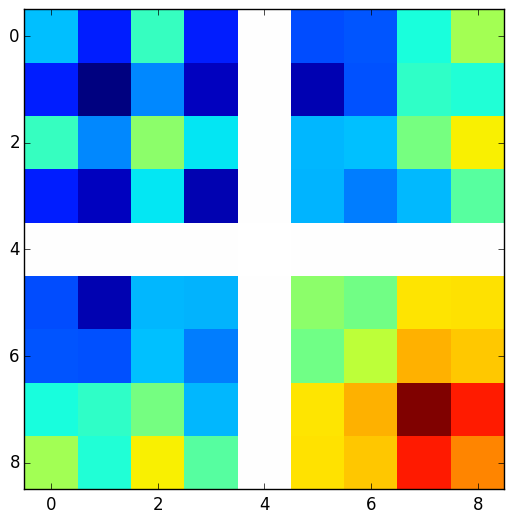

  0.214521 seconds (570 allocations: 9.664 MB, 8.22% gc time)
-2.2674380072492184
[0.3597905085402707,0.07293412600809199,1.0548565434064499,0.14280147184250933,-0.0,1.2230892228438195,-1.6584524041498887,10.412059598968794,4.252574443945852]


PyObject <matplotlib.image.AxesImage object at 0x316e63590>

In [32]:
### =============== testing 2 ================= ####
@time LL, LLgrad, LLhess = single_trial(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice, 1)
println(LL)
println(LLgrad)
# println(LLhess)
imshow(log(abs(LLhess)), interpolation="none")
### =========================================== ####

In [18]:
LL

-2.2674380072492184

In [19]:
LLgrad

9-element Array{Float64,1}:
  0.359791 
  0.0729341
  1.05486  
  0.142801 
 -0.0      
  1.22309  
 -1.65845  
 10.4121   
  4.25257  

In [20]:
LLhess

9x9 Array{Float64,2}:
 -0.182741   -0.036041    -0.514579  …   0.0628717    -0.366137   -1.9298  
 -0.036041   -0.00767092  -0.104497      0.0617207    -0.477641   -0.391196
 -0.514579   -0.104497    -1.51706       0.187104     -1.11929    -5.65792 
 -0.0365256  -0.0137524    0.271479      0.0936496     0.171256   -0.765942
  0.0         0.0          0.0          -0.0           0.0         0.0     
 -0.0582436  -0.0119975   -0.17262   …  -1.03111       6.50581    -6.56027 
  0.0628717   0.0617207    0.187104     -2.71763      11.0167      8.89542 
 -0.366137   -0.477641    -1.11929      11.0167     -187.23      -55.847   
 -1.9298     -0.391196    -5.65792       8.89542     -55.847     -18.0844  

In [21]:
#Pkg.update()

# Maximize LL over parameter space
### Optimization with Optim.jl


In [22]:
# Pkg.add("Optim")

# import Optim
# using Optim

In [34]:
function SumLikey_LL(params::Vector, ratdata, ntrials::Int)
    LL        = 0.
        
    for i in 1:ntrials
        RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], i)
        Nsteps = Int(ceil(maxT/dt))

        LLi = logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
        LL        = LL + LLi;
    end
    
    LL = -LL
    return LL
end

function SumLikey(params::Vector, ratdata, ntrials::Int)
    LL        = 0.
    LLgrad    = zeros(Float64,length(params))
    
    for i in 1:ntrials
        if rem(i,1000)==0
            println("     sum_ll_all_trials: running trial ", i, "/", ntrials);
        end

        RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], i)
        Nsteps = Int(ceil(maxT/dt))

        LLi, LLgradi = single_trial(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
        LL        = LL + LLi;
        LLgrad    = LLgrad + LLgradi;
        
    end

    LL = -LL
    LLgrad = -LLgrad
    return LL, LLgrad
end

SumLikey (generic function with 1 method)

In [57]:
@time SumLikey_LL(params, ratdata, 27) # sum of LL for trial (1-27)

  0.034994 seconds (4.87 k allocations: 4.562 MB)


20.89222968453269

In [58]:
@time SumLikey(params, ratdata, 27)

  0.127168 seconds (18.20 k allocations: 36.089 MB, 5.84% gc time)


(20.892229684532673,[-1.2705361959151216,-0.2795685316150146,-4.9051899858865555,-0.3886150073149204,-0.0,-0.19494683541134517,4.037801445756479,-40.24554053058176,-31.900764365874725])

In [48]:
function Likely_all_trials{T}(LL::AbstractArray{T,1},params::Vector, ratdata, ntrials::Int)     
    for i in 1:ntrials
        RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], i)
        Nsteps = Int(ceil(maxT/dt))

        LL[i] = logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
    end
end

Likely_all_trials (generic function with 1 method)

In [49]:
ntrials = 27
likely_all = zeros(ntrials)
@time Likely_all_trials(likely_all, params, ratdata, ntrials)
likely_all

  0.056168 seconds (13.71 k allocations: 4.910 MB)


27-element Array{Float64,1}:
 -2.26744  
 -0.0616022
 -0.0531116
 -2.83579  
 -0.0715407
 -2.20578  
 -0.0512972
 -0.0513275
 -1.34728  
 -0.0581925
 -1.04467  
 -0.0515327
 -0.163206 
  ⋮        
 -0.0513612
 -0.0537381
 -1.11915  
 -0.0520757
 -0.162861 
 -0.0532742
 -2.9953   
 -0.644379 
 -1.78951  
 -0.0780455
 -0.0512951
 -0.0945155

In [50]:
# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]

ntrials = 27

function LL_f(params::Vector)
    return SumLikey_LL(params, ratdata, ntrials)
end

function LL_g!(params::Vector, grads::Vector)
#     LL, LLgrad, LLhess = llikey(params)
    LL, LLgrad = SumLikey(params, ratdata, ntrials)
    for i=1:length(params)
        grads[i] = LLgrad[i]
    end
end

function LL_fg!(params::Vector, grads)
    LL, LLgrad = SumLikey(params, ratdata, ntrials)
    for i=1:length(params)
        grads[i] = LLgrad[i]
    end
    return LL
end

d4 = DifferentiableFunction(LL_f,
                            LL_g!,
                            LL_fg!)

Optim.DifferentiableFunction(LL_f,LL_g!,LL_fg!)

In [51]:
# Parameters
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 6.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]

l = [0, 0, 0, -5, 5, -5, 0.01, 0.005, 0]
u = [200, 200, 30, +5, 25, +5, 1.2, 0.7, 1]

# test with max_iteration = 10 
res = optimize(d4, params, l, u, Fminbox(); 
         optimizer = GradientDescent, optimizer_o = OptimizationOptions(g_tol = 1e-12,
                                                                        iterations = 10,
                                                                        store_trace = true,
                                                                        show_trace = true))


Iter     Function value   Gradient norm 
 

    0     2.086867e+01     4.026169e+01
     1     1.640741e+01     1.903768e+00
     2     1.612624e+01     7.460709e-01
     3     1.607483e+01     8.825951e-01
     4     1.605209e+01     4.439360e-01
     5     1.600958e+01     1.136077e+00
     6     1.598516e+01     3.163914e-01
     7     1.597285e+01     5.535301e-01
     8     1.596478e+01     4.013451e-01
     9     1.595813e+01     2.860264e-01
    10     1.595250e+01     3.893248e-01
Iter     Function value   Gradient norm 
     0     1.597820e+01     4.157853e-01
     1     1.597124e+01     2.189507e-01
     2     1.595994e+01     4.913362e-01
     3     1.594856e+01     1.944350e-01
     4     1.594570e+01     2.974205e-01
     5     1.594245e+01     1.799034e-01
     6     1.593899e+01     3.008426e-01
     7     1.593516e+01     1.556938e-01
     8     1.592298e+01     7.682509e-01
     9     1.590019e+01     3.695476e-01
    10     1.589634e+01     3.261187e-01
Iter     Function value   Gradient norm 
     0     1.5896

LoadError: LoadError: InterruptException:
while loading In[51], in expression starting on line 12

In [ ]:
res.minimum

In [ ]:
res

In [ ]:
# include("AutodiffModule.jl")
# import AutodiffModule
# using MAT
# using Optim

function main()

    server = 0
    if server > 0 
        ratname = readline(STDIN) #<- $echo $ratname | julia t3.jl  #"B069"
        ratname = ratname[1:end-1] 
    else
        ratname = "B069"
    end
    
    # data import
    if server > 0 
        mpath = "/mnt/bucket/people/amyoon/Data/PBupsModel_rawdata/"
    else
        mpath = "./"
    end
    ratdata = matread(*(mpath,"chrono_",ratname,"_rawdata.mat"))

    println("rawdata of ", ratname, " imported" )

    saveto_filename = *("julia_out_",ratname,".mat")

    # number of trials
    ntrials = Int(ratdata["total_trials"])

    # Parameters
    sigma_a = rand()*4.; sigma_s = rand()*4.; sigma_i = rand()*30.; 
    lam = randn(); B = rand()*20.+5.; bias = randn(); 
    phi = rand()*1.19+0.01; tau_phi = 0.695*rand()+0.005; lapse = rand();

    # sigma_a = 1.; sigma_s = 0.1; sigma_i = 0.2; 
    # lam = -0.0005; B = 6.1; bias = 0.1; 
    # phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
    params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]

    l = [0.,   0.,   0., -5., 5., -5., 0.01, 0.005, 0.]
    u = [200., 200., 30., 5., 25., 5., 1.2,  0.7,   1.]

    # @code_warntype SumLikey(params, ratdata, ntrials)

    function LL_f(params::Vector)
        return AutodiffModule.SumLikey_LL(params, ratdata, ntrials)
    end

    function LL_g!(params::Vector, grads::Vector)
#         LL, LLgrad = AutodiffModule.SumLikey(params, ratdata, ntrials)
        LL, LLgrad = SumLikey(params, ratdata, ntrials)        
        for i=1:length(params)
            grads[i] = LLgrad[i]
        end
    end

    function LL_fg!(params::Vector, grads)
#         LL, LLgrad = AutodiffModule.SumLikey(params, ratdata, ntrials)
        LL, LLgrad = SumLikey(params, ratdata, ntrials)
        for i=1:length(params)
            grads[i] = LLgrad[i]
        end
        return LL
    end

    d4 = DifferentiableFunction(LL_f,
                                LL_g!,
                                LL_fg!)

    tic()
    history = optimize(d4, params, l, u, Fminbox(); 
             optimizer = GradientDescent, optimizer_o = OptimizationOptions(g_tol = 1e-12,
                                                                            x_tol = 1e-10,
                                                                            f_tol = 1e-6,
                                                                            iterations = 200,
                                                                            store_trace = true,
                                                                            ))
    fit_time = toc()
    println(history.minimum)
    println(history)

    ## do a single functional evaluation at best fit parameters and save likely for each trial
    likely_all = zeros(typeof(sigma_i),ntrials)
    x_bf = history.minimum
    Likely_all_trials(likely_all, x_bf, ratdata, ntrials)

    matwrite(saveto_filename, Dict([("ratname",ratname),
                                    ("x_init",params),
                                    ("trials",ntrials),
                                    ("history",history),
                                    ("f",history.f_minimum), 
                                    ("x_converged",history.x_converged),
                                    ("f_converged",history.f_converged),
                                    ("g_converged",history.g_converged),                                    
                                    ("fit_time",fit_time),
                                    ("x_bf",history.minimum),
                                    ("myfval", history.f_minimum),
                                    ("likely",likely_all)
                                    ]))
     # hessian?

end

In [ ]:
main()